In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson

#to en otra carpeta
sns.set_theme()

$$T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \hspace{2 mm} (1)$$

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})\right]$$

In [2]:
def delta(m,n):
  '''
  Delta de Kronecker.
  '''
  if m==n: return 1
  else: return 0

def p(m):
    '''
    Productoria de la expresión (1)
    '''
    pro=1
    for n in range(0,m+1):
        pro=pro*(2*(m-n)+delta(m,n))/(2*(m-n)+1)
    return pro


# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b




# Cambio de corriente a distancia focal
def focalcurr(ecu,corr):
  '''
  Cambio de corriente [mA] a distancia focal [m]

  Parametros
  ----------
  ecu: String
      Parametro tipo cadena 'opt1' o 'opt2' dependiendo
      del tipo de ecuación de ajuste.
  corr: Arreglo
      Arreglo con distancias focales utilizadas.

  La función devuelve la distancia focal
  '''
  if(ecu=='opt1'):
      focal = 1/(0.045*corr + 1.522)
  elif(ecu=='opt2'):
      focal = (1/(5.9e-5*corr + 4.9e-3) + 1.7)*1e-3
  return focal

def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
   
    señal_ruido=np.zeros(len(señal))
    señal_ruido=[ np.random.normal(señal[i], desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

# Archivo con los datos que se asumiran como reales.
df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)

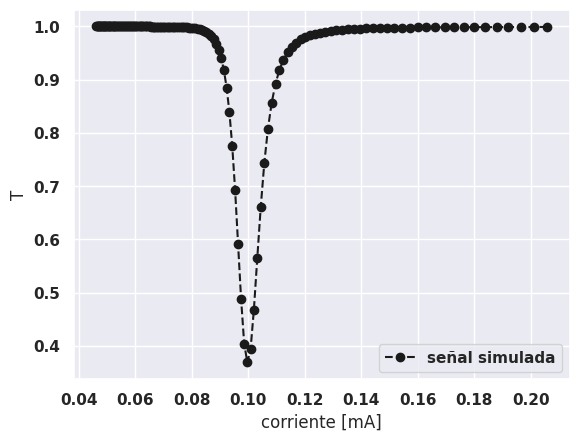

In [3]:
# Señal con ruido.
# Corriente con menos puntos cerca de la caida.
corriente=[i for i in range(0,300,2)]

corriente=np.array(corriente)
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 100e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ


T=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
#Td= np.gradient(T)

#Pavg=Pavg+0.05*Pavg
#L=L+0.05*L
#ds=ds+0.05*ds
plt.plot(focal,T,'--ko',label='señal simulada')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T')
plt.xlabel('corriente [mA]')
plt.legend()


In [4]:
BETA(val_min,focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)

5.000000000000001e-09

In [5]:
# -*- coding: utf-8 -*-
#Función de Ajuste 
def dist_betas(N,desv): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]

  L_c = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
  L_e = float(df.loc['L_e']['Valor'])*float(df.loc['L_e']['Valor2']) # thickness error

  Pavg_c = float(df.loc['Pavg_c']['Valor'])*float(df.loc['Pavg_c']['Valor2']) # Average power in (W)
  Pavg_e = float(df.loc['Pavg_e']['Valor'])*float(df.loc['Pavg_e']['Valor2']) # Average power error

  Tp_c = float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
  Tp_e = float(df.loc['Tp_e']['Valor'])*float(df.loc['Tp_e']['Valor2']) # pulse width error

  wl_c = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
  wl_e = float(df.loc['wl_e']['Valor'])*float(df.loc['wl_e']['Valor2']) # central wavelength error

  D_c = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
  D_e = float(df.loc['D_e']['Valor'])*float(df.loc['D_e']['Valor2']) # beam diameter error
  
  ds_c = float(df.loc['ds_c']['Valor'])*float(df.loc['ds_c']['Valor2']) # Distance EFTL-sample (m)
  ds_e = float(df.loc['ds_e']['Valor'])*float(df.loc['ds_e']['Valor2']) # distance EFTL-sample error

  Cf_c = float(df.loc['Cf_c']['Valor']) # beam correction coeff
  Cf_e = float(df.loc['Cf_e']['Valor'])

  alfa_c = float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
  alfa_e = float(df.loc['alfa_e']['Valor'])

  R_c = float(df.loc['R_c']['Valor']) # reflection percentage 
  R_e = float(df.loc['R_e']['Valor'])

  freq_c = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
  freq_e = float(df.loc['freq_e']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)

  corriente=[i for i in range(0,300,2)]
  corriente=np.array(corriente)
  focal=focalcurr('opt2',corriente) #focal distance [m]

  TT=list(fscanTH2(focal,beta,L_c,Pavg_c,Tp_c,wl_c,D_c,ds_c,Cf_c,alfa_c,R_c,freq_c)) #Señal simulada
  trans=min(TT) #Minimo de la señal simulada.
  index=T.index(min(T))
  # Corriente con menos puntos cerca de la caida.
  
  f=focal[index]  #Distancia focal correspondiente al minimo.
     
  for ii in range(N):
      
      er=desv/100
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L_c,L_c*er,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg_c,Pavg_c*er,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp_c,Tp_c*er,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl_c,wl_c*er,1) #central wavelength in (m)
      D_f = np.random.normal(D_c,D_c*er,1) # beam diameter in (m)
      ds_f = np.random.normal(ds_c,ds_c*er,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf_c,Cf_c*er,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa_c,alfa_c*er,1)) #linear absorption (1/m)
      R_f = np.random.normal(R_c,R_c*er,1) # Reflectance
      freq_f = np.random.normal(freq_c,freq_c*er,1) # Reflectance
      trans_f= np.random.normal(trans,trans*er,1)
      focal_f=np.random.normal(f,f*er,1)
      TPA.append(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
  return TPA

A-D statistic: 0.3212114209673018
Critical values: [0.576 0.655 0.786 0.917 1.091]
Significance levels: [15.  10.   5.   2.5  1. ]


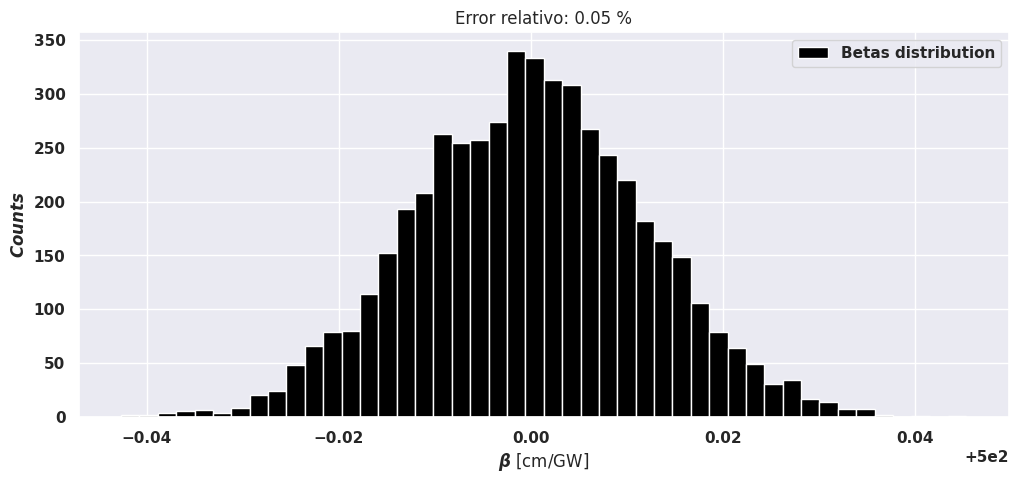

In [19]:
from scipy.stats import kstest

#perform Kolmogorov-Smirnov test
f=plt.figure(figsize=(12,5))
er_r=0.0005
beta_hist=np.array(dist_betas(5000,er_r))
result = kstest(beta_hist, cdf='norm')
plt.hist(beta_hist,bins='fd',color='black',label='Betas distribution')
plt.xlabel(r'$\beta$ [cm/GW]')
plt.title('Error relativo: '+str(er_r*100)+' %' )
plt.ylabel('$Counts$')
plt.legend()
result = (anderson(np.sort(beta_hist), dist='norm'))
print(f"A-D statistic: {result[0]}")
print(f"Critical values: {result[1]}")
print(f"Significance levels: {result[2]}")